In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as onp
import jax.numpy as np
import numpy as num
from jax import grad, jit, vmap, value_and_grad
from jax import random
import jax

import seaborn as sns
import matplotlib.pyplot as plt

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Работа делится на три части. Нужно различным способом получить матрицу W в нейронной модели. В нашем случае, это простой MLP:

1. Просемплировать матрицу W из нормального распредления для каждого мини-батча размера $m \times n$.
2. Просемплировать матрицу W из нормального распредления для каждого элемента мини-батча размера $base\_size \times m \times n$.
3. Рассмотрим один из слоев в нашей нейронной сети: входная матрица признаков A размером $M \times 512$, которая умножается на весовую матрицу W размером $512 \times 512$, прежде чем будет применена нелинейность, мы получаем результат $\textbf{B} = \textbf{A}\textbf{W}$. Затем мы задаем апостериорную аппроксимацию весов как полностью факторизованную гауссову, т.е. $q_\phi(w_{i, j}) = \mathcal{N}(\mu_{i, j}, \sigma_{i, j}^2) \; \forall w_{i, j} \in \textbf{W}$, что означает, что веса выбираются как $w_{i, j} = \mu_{i, j} + \sigma_{i, j} \epsilon_{i, j}, \text{ with } \epsilon_{i, j} \sim \mathcal{N}(0, 1)$
 

Тогда будет работать с $\textbf{B}$(семплировать случайные активации)
	
\begin{equation}
  \begin{split}
    q_\psi(w_{i, j}) &= \mathcal{N}(\mu_{i, j}, \sigma_{i, j}^2) \; \forall w_{i, j} \in \textbf{B} \Longrightarrow q_\phi(b_{m, j} | A) = \mathcal{N}(\gamma_{im, j}, \delta_{m, j}), \text{ with} \\
    \gamma_{m, j} &= \sum\limits_{i=1}^{512} a_{m, i} \mu_{i, j}, \text{ and } \delta_{m, j} = \sum\limits_{i=1}^{512} a_{m, i}^2 \sigma_{i, j}^2
  \end{split}
\end{equation}

\begin{equation*}
  b_{m,j} = \gamma_{m,j} + \sqrt{\delta_{m,j}} \zeta_{m, j}, \text{ with } \zeta_{m, j} \sim \mathcal{N}(0, 1), \; \zeta \in \mathbb{R}^{M \times 512}.
\end{equation*}

In [2]:
sns.set(context='poster', style='white',
        font='sans-serif', font_scale=1, color_codes=True, rc=None)


def plot_mnist_performance(train_loss, train_acc, test_acc,
                           sup_title="Loss Curve"):
    """ Visualize the learning performance of a classifier on MNIST """
    fig, axs = plt.subplots(1, 1, figsize=(10, 4))
    axs.plot(train_loss)
    axs.set_xlabel("# Batch Updates")
    axs.set_ylabel("Batch Loss")
    axs.set_title("Training Loss")
    #for i in range(1):
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)

    fig.suptitle(sup_title, fontsize=25)
    fig.tight_layout(rect=[0, 0.03, 1, 0.925])

In [3]:
def ReLU(x):
    return np.maximum(0, x)

jit_ReLU = jit(ReLU)

def FiniteDiffGrad(x):
    return np.array((ReLU(x + 1e-3) - ReLU(x - 1e-3)) / (2 * 1e-3))

In [4]:
def scan(init, xs, b,length=None):
    if xs is None:
        xs = [None] * length
    carry = init
    ys = []
    for i in range(len(xs.shape)): 
        y = np.dot(xs[i].T, carry[i, :, :]) + b[i] 
        ys.append(y) 
    return np.stack(ys)[0].sum(axis=-1)

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def relu_layer_sep(params, x): 
    return ReLU(scan(params[0], x, params[1]))

def batch_version_relu_layer(params, x):
    """ Error prone batch version """
    return ReLU(np.dot(X, params[0].T) + params[1])

def vmap_relu_layer(params, x):
    """ vmap version of the ReLU layer """
    return jit(vmap(relu_layer, in_axes=(None, 0), out_axes=0))

## Работа с MNIST

In [5]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.example_libraries import optimizers

import torch
from torchvision import datasets, transforms

import time

In [6]:
#!pip install seaborn

In [7]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

## Общие функции

In [41]:
rng = num.random.RandomState(42)
def salimans_sample(shape):
    w = rng.normal(0,1,(shape[0],shape[1]))
    w -= np.mean(w, axis=0, keepdims=True)
    w /= np.sqrt(np.sum(np.square(w), axis=0, keepdims=True))
    return w.astype('float64')

def _logit(x):
    """
    Logit function in Numpy. Useful for parameterizing alpha.
    """
    return np.log(x/(1. - x))

def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds, mean, logvar = batch_forward(params, in_arrays)
    return -np.sum(preds * targets)
 
def kl_divergence(params, in_arrays, targets):
    preds, mean, logvar = batch_forward(params, in_arrays) 
    loss_total = -0.5 * np.sum(1 + logvar - mean ** 2 - np.exp(logvar)) - np.sum(preds * targets)
    return loss_total

In [42]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """ 
    value, grads = value_and_grad(kl_divergence)(params, x, y)
    opt_state = opt_update(0, grads, opt_state) 
    return get_params(opt_state), opt_state, value

In [43]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP", sampling="1"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss, train_loss_kl = [], [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            x = np.array(data).reshape(data.size(0), 28*28)
 
            y = one_hot(np.array(target), num_classes)
 
            params, opt_state, kl_loss = update(params, x, y, opt_state) 
 
            if batch_idx % 100 == 0 and sampling=="2":
                print(kl_loss)
            
            train_loss_kl.append(kl_loss)

        epoch_time = time.time() - start_time
        print("Epoch {} | T: {:0.2f} | Elbo loss: {:0.4f} |".format(epoch+1, epoch_time, num.mean(train_loss_kl)))

    return train_loss_kl, log_acc_train, log_acc_test

## Реализация метода 1(сэмплирование весов для каждого батча)

In [11]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))

    def initialize_layer(m, n, key, scale=1e-2):
        rng = num.random.RandomState(42)
        def salimans_sample(shape):
            w = rng.normal(0,1,(shape[0],shape[1]))
            w -= np.mean(w, axis=0, keepdims=True)
            w /= np.sqrt(np.sum(np.square(w), axis=0, keepdims=True))
            return w.astype('float64')
        w_key, b_key = random.split(key)
        #print(w_key)
        p = 0.5
        logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')
        alpha = jax.nn.sigmoid(logitalpha)
        W = salimans_sample((n, m))
        W_noised = W*(1. + random.normal(w_key, W.shape)*np.sqrt(alpha))

        #print((scale *W_noised).shape)
        return  scale *W_noised, scale * random.normal(b_key, (n,))

    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 10]
params = initialize_mlp(layer_sizes, key)
#print(len(params))

/tmp/ipykernel_1969077/2348627112.py:15: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')
/tmp/ipykernel_1969077/2348627112.py:11: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return w.astype('float64')


In [12]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array
    #print(params[0][0], params[0][1])
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)

    final_w_mean, final_b_mean = params[-1]
    final_w_logvar, final_b_logvar = params[-1]
    final_w, final_b = params[-1]
    
    mean = np.dot(final_w_mean, activations) + final_b_mean
    logvar = np.dot(final_w_logvar, activations) + final_b_logvar
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits), mean, logvar #logits - logsumexp(logits) #- logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

In [13]:
def kl_divergence(params, in_arrays, targets):
    preds, mean, logvar = batch_forward(params, in_arrays) 
    loss_total = -0.5 * np.sum(1 + logvar - mean ** 2 - np.exp(logvar)) - np.sum(preds * targets) 
    return loss_total

Epoch 1 | T: 11.55 | Elbo loss: 208.0315 |
Epoch 2 | T: 11.26 | Elbo loss: 207.1632 |
Epoch 3 | T: 11.17 | Elbo loss: 206.7462 |
Epoch 4 | T: 11.22 | Elbo loss: 206.4849 |
Epoch 5 | T: 11.06 | Elbo loss: 206.3009 |


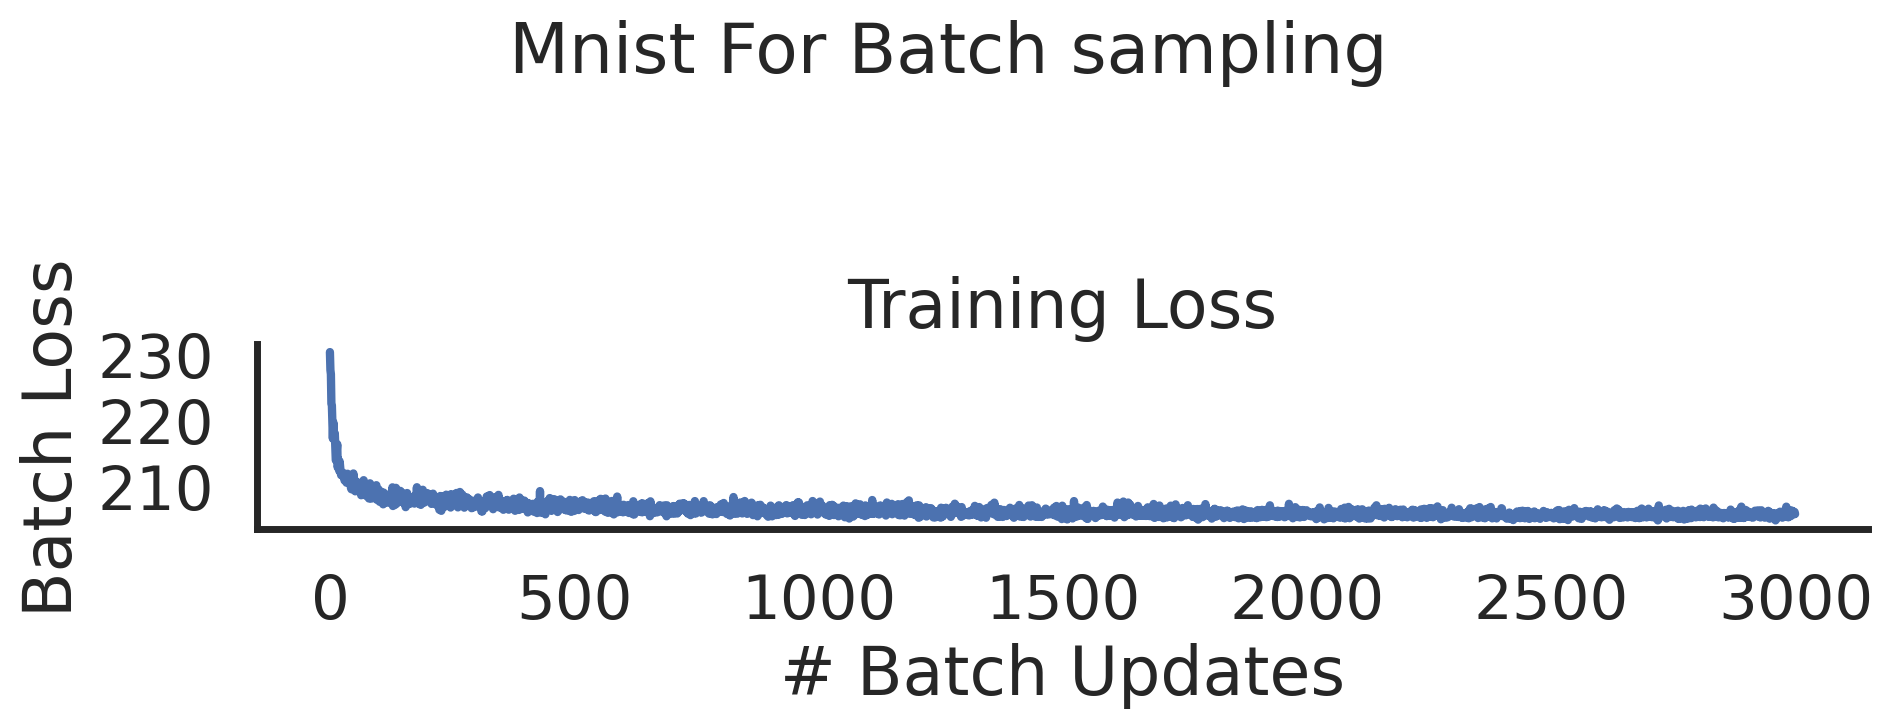

In [14]:
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params) 

num_epochs = 5
num_classes = 10
train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")

# Plot the loss curve over time
#from helpers import plot_mnist_performance
plot_mnist_performance(train_loss, train_log, test_log,
                       "Mnist For Batch sampling")

In [ ]:
## лосс ~ 0.21 * 10^3, время ~ 11sec

## Реализация метода 2(сэмплирование весов для каждого элемента батча)

In [15]:
input_shape = 100
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))

    def initialize_layer(m, n, key, scale=1e-2):
        rng = num.random.RandomState(42)
        input_shape
        def salimans_sample(shape):
            w = rng.normal(0,1,(shape[0],shape[1]))
            w -= np.mean(w, axis=0, keepdims=True)
            w /= np.sqrt(np.sum(np.square(w), axis=0, keepdims=True))
            return w.astype('float64')
        w_key, b_key = random.split(key)
        #print(w_key)
        p = 0.5
        logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')
        alpha = jax.nn.sigmoid(logitalpha)
        W = salimans_sample((n, m))
        #W_noised = W*(1. + random.normal(w_key, W.shape)*np.sqrt(alpha))

        W_noised = W*(1 + random.normal(w_key, (100,
                        W.shape[0],
                        W.shape[1]))*np.sqrt(alpha))

        #print((scale *W_noised).shape)
        return  scale *W_noised, scale * random.normal(b_key, (n,))

    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
params = initialize_mlp(layer_sizes, key)
print(len(params))

/tmp/ipykernel_1969077/1670349637.py:17: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')
/tmp/ipykernel_1969077/1670349637.py:13: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return w.astype('float64')


3


In [16]:
random.split(key, len(layer_sizes))

Array([[ 869452973, 4133157646],
       [ 261504626, 4112007671],
       [3597360905,  253918841],
       [  98387565,  678776088]], dtype=uint32)

In [17]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer_sep([w, b], activations)
        
    final_w_mean, final_b_mean = params[-1]
    final_w_logvar, final_b_logvar = params[-1]
    final_w, final_b = params[-1]
    
    mean = (np.dot(final_w_mean, activations) + final_b_mean).sum(axis=0)
    logvar = (np.dot(final_w_logvar, activations) + final_b_logvar).sum(axis=0)
    logits = (np.dot(final_w, activations) + final_b).sum(axis=0)
    return logits - logsumexp(logits), mean, logvar

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

1348.2806
230.45642
230.43025
230.45282
230.3172
230.12933
Epoch 1 | T: 500.63 | Elbo loss: 240.3019 |
230.45065
230.49217
230.87167
230.01723
230.27951
230.46162
Epoch 2 | T: 506.17 | Elbo loss: 235.3364 |
230.4071
230.3141
230.30899
230.20265
230.21472
230.38559
Epoch 3 | T: 408.26 | Elbo loss: 233.6836 |
230.41663
230.27388
230.27673
230.19528
230.44974
230.40903
Epoch 4 | T: 415.33 | Elbo loss: 232.8603 |
230.60883
230.50023
230.49857
230.56998
230.27295
230.49377
Epoch 5 | T: 421.21 | Elbo loss: 232.3699 |


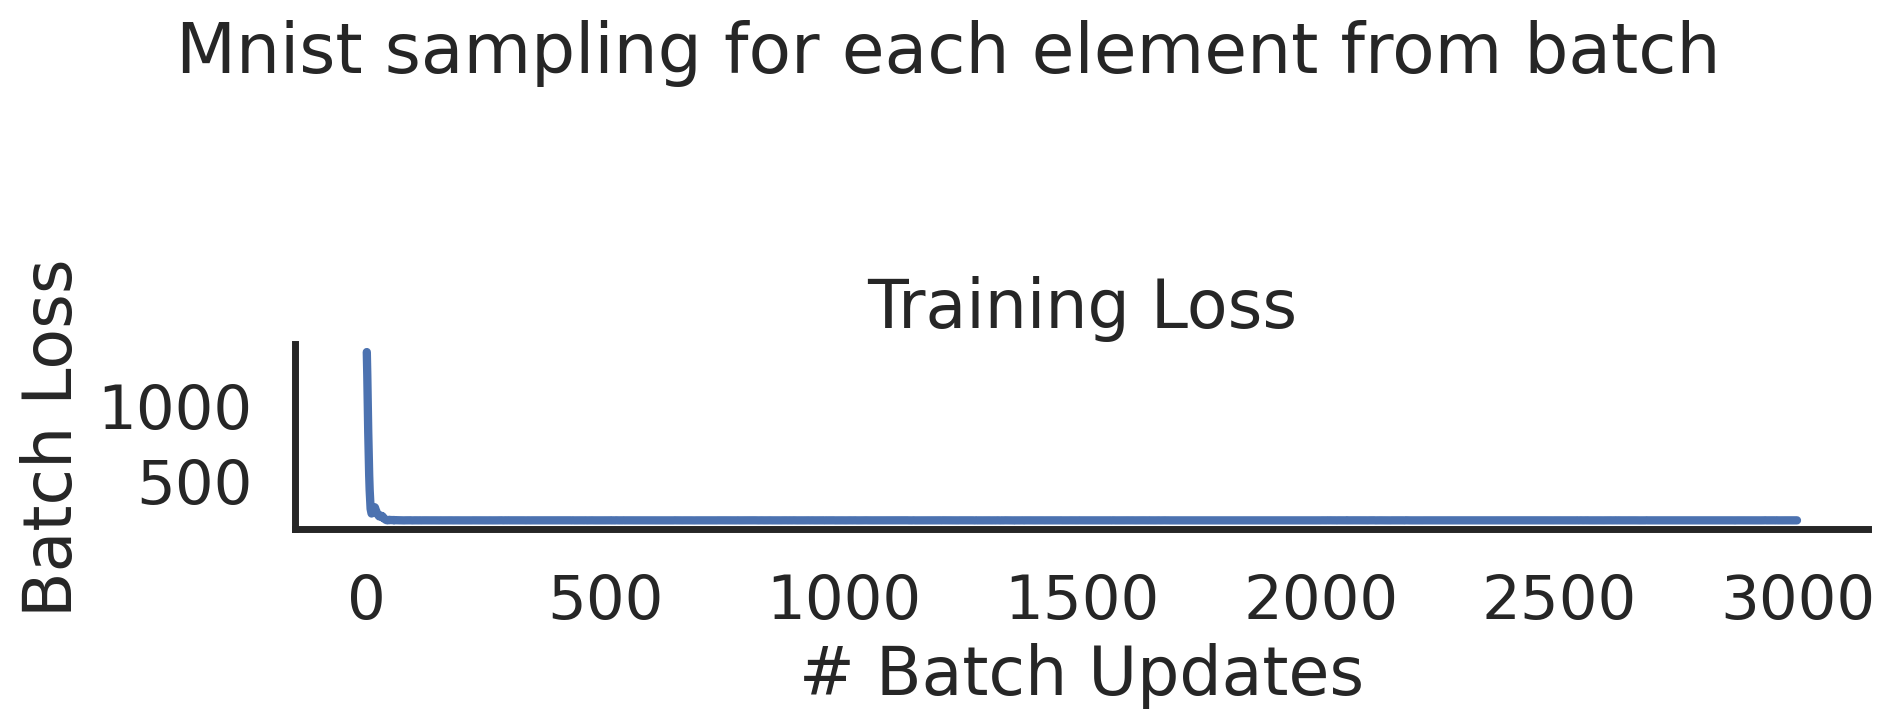

In [18]:
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 5
num_classes = 10
train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP",
                                                          sampling ="2")

# Plot the loss curve over time
#from helpers import plot_mnist_performance
plot_mnist_performance(train_loss, train_log, test_log,
                       "Mnist sampling for each element from batch")

In [ ]:
## лосс ~ 0.24 * 10^3, время ~ 500 сек почти в 50 раз медленнее 1 метода

## Local Reparametrization

In [82]:
from flax import linen as nn

In [83]:
#!pip install flax

In [181]:
from typing import Sequence, Callable

class MultiLayerPerceptron(nn.Module):
    p = 0.5
    hidden_neurons: Sequence[int]
    kernel_init: Callable = nn.initializers.lecun_normal()
    activation: Callable = nn.tanh
    logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')
    alpha = jax.nn.sigmoid(logitalpha)
    llayer = nn.Dense(features=10)
    
    def new_linear(self,x, neurons, scale=1e-2):
        theta = self.kernel_init(jax.random.PRNGKey(42), x.shape, np.float64)
        mu_z = x #nn.Dense(neurons, kernel_init=self.kernel_init)(x)
        sigma_z = np.sqrt(np.dot(np.square(x[1]), self.alpha*np.square(theta)[0]))
        randn = num.random.normal(size=x[0].shape) 
        return mu_z + sigma_z*randn
    
    @nn.compact
    def __call__(self, x): 
        for k, neurons in enumerate(self.hidden_neurons):
            x = nn.Dense(neurons, kernel_init=self.kernel_init)(x)
            x = self.new_linear(x, neurons)
            #print(x.shape)
            if k != len(self.hidden_neurons) - 1:
                x = self.activation(x)
            #x = self.new_linear(x, neurons)
        return x

/tmp/ipykernel_475989/444684596.py:8: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')


In [182]:
class MLP(nn.Module): 
    @nn.compact
    def __call__(self, x):
        x = MultiLayerPerceptron([748, 512, 256], activation=nn.tanh)(x)
        #print(x.shape)
        mean = nn.Dense(features=10)(x)
        logvar = nn.Dense(features=10)(x)
        logits = nn.Dense(features=10)(x)
        #print(mean.shape)
        return logits, mean, logvar

In [183]:
import optax
from flax.training import train_state


def create_train_state(rng):
    """Creates initial `TrainState`."""
    param_rng, z_rng = jax.random.split(rng)

    mlp = MLP()
    params = mlp.init(param_rng, np.ones([1, 28 * 28]))['params']
    tx = optax.adam(0.001)
    return train_state.TrainState.create(
    apply_fn=mlp.apply, params=params, tx=tx)

rng = jax.random.PRNGKey(42)
state = create_train_state(rng)
def get_mlp(params, x):
    logits, mean, logvar = state.apply_fn({'params': params['params']}, x)
    return logits, mean, logvar

In [184]:
mlp = MLP()
#batch_forward = vmap(get_mlp, in_axes=(None, 0), out_axes=0)

In [185]:
#!pip install jax_metrics

In [186]:
def kl_divergence(params, in_arrays, targets, loss='1'):
    #print('ok')
    preds, mean, logvar = get_mlp(params, in_arrays)  
    loss_total = -0.5 * np.sum(1 + logvar - mean ** 2 - np.exp(logvar)) - np.sum(preds * targets) #- np.sum(preds * targets)
    #print(loss_total)
    return loss_total

In [187]:
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    #grad_fn = jax.value_and_grad(kl_divergence, has_aux=True)
    #value, grads = grad_fn(params)
    value, grads = value_and_grad(kl_divergence)(params, x, y) #loss
    opt_state = opt_update(0, grads, opt_state) 
    return get_params(opt_state), opt_state, value

Epoch 1 | T: 46.61 | Elbo loss: -1196.9543 |
Epoch 2 | T: 46.53 | Elbo loss: -25282.0410 |
Epoch 3 | T: 46.34 | Elbo loss: -58645.6719 |
Epoch 4 | T: 46.45 | Elbo loss: -95697.0703 |
Epoch 5 | T: 46.93 | Elbo loss: -135310.5469 |


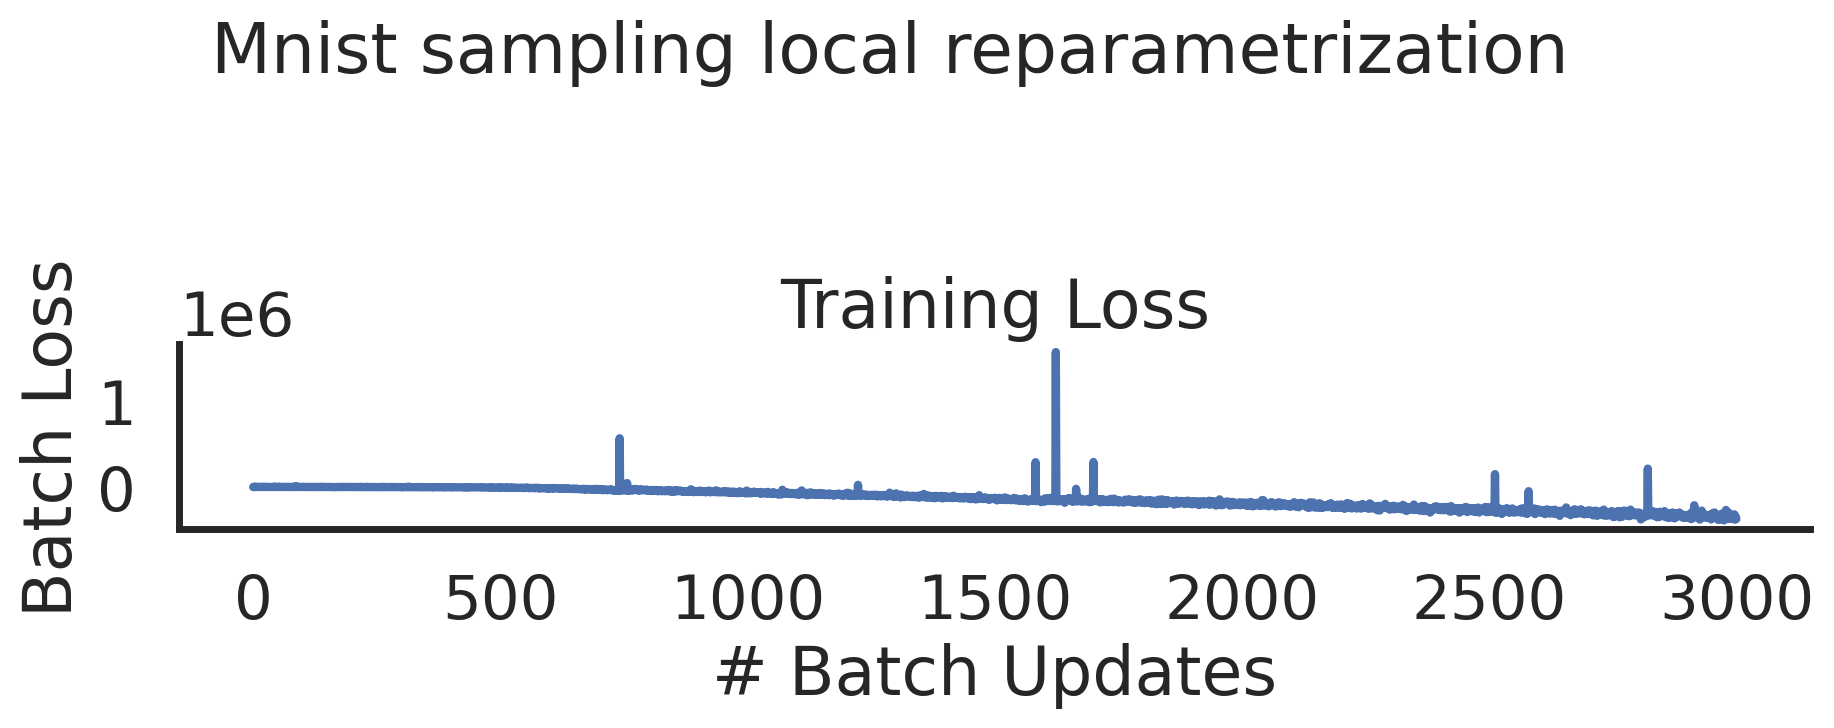

In [188]:
step_size = 1e-3
params = mlp.init(random.PRNGKey(42), np.ones([1, 28 * 28]))
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
#params = mlp.init(random.PRNGKey(42), np.ones([1, 28 * 28]))
num_epochs = 5
num_classes = 10
train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP",
                                                          sampling ="1")

# Plot the loss curve over time
#from helpers import plot_mnist_performance
plot_mnist_performance(train_loss, train_log, test_log,
                       "Mnist sampling local reparametrization")

### Вывод

##### Реализованы три метода по различным стратегиям по сэмплированию в нейронных моделях. Но тут можно еще дорабатывать. Но к сожалению, не успела(( Но лосс в последнем случае самый наименьший(~-1.1*10^(3))

##### По времени метод 1, 3 быстрее 2, что написано и в статье, так как мы семплируем очень много параметров только для одного слоя, когда их несколько, нужно умножать на n